# Read data and import libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./datasets/BATADAL_dataset03.csv')
df.head()

,DATETIME,L_T1,L_T2,L_T3,L_T4,L_T5,L_T6,L_T7,F_PU1,S_PU1,...,P_J256,P_J289,P_J415,P_J302,P_J306,P_J307,P_J317,P_J14,P_J422,ATT_FLAG
0,06/01/14 00,0.509730,2.049003,3.191145,2.792634,2.656091,5.316831,1.562321,98.998444,1,...,87.605774,26.495605,84.206619,18.901676,81.983734,18.791777,67.125603,29.387470,28.487471,0
1,06/01/14 01,0.412580,2.009072,3.642565,2.831673,3.126387,5.494855,1.852043,99.095901,1,...,89.448341,26.487326,85.900085,18.849329,82.150589,18.739643,67.178696,29.354256,28.454256,0
2,06/01/14 02,0.320112,1.986093,4.140192,3.256733,3.574601,5.500000,2.246126,98.420959,1,...,91.056114,26.487364,86.582474,19.597170,83.988579,19.496712,72.425293,29.354538,28.454538,0
3,06/01/14 03,0.332879,2.009203,4.673478,3.744497,3.952379,5.500000,3.203573,97.575172,1,...,92.594353,26.575815,88.020546,26.028486,64.670486,25.922703,76.275040,29.449951,28.549952,0
4,06/01/14 04,0.483496,2.089049,5.237937,4.409456,3.504676,5.500000,4.439714,97.351059,1,...,94.473099,26.723457,90.422462,26.209970,64.746620,26.104692,76.703529,29.574265,28.674263,0


# Create correlation matrix

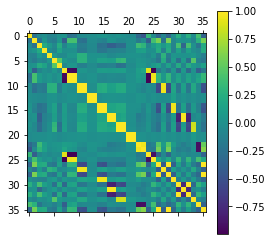

In [6]:
## remove the prediction attribute: ATT_FlAG
## remove the timestamp
filtered_df = df.copy()
filtered_df = filtered_df.drop(columns=['ATT_FLAG', 'DATETIME'])

# constants cannot be used to detect s
constants = [x for x in filtered_df if np.std(filtered_df[x]) == 0]
filtered_df = filtered_df.drop(columns=constants)

# plot the correlation matrix
plt.matshow(filtered_df.corr())
plt.colorbar()
plt.show()


# Plot the cyclic behaviour of F_PU1 and P_J280 in 1 plot
# Correlation was found inside the correlation matrix

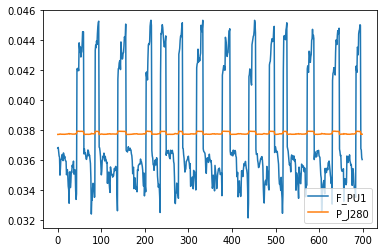

In [11]:
import sklearn
from sklearn.preprocessing import normalize
attributes = list(df.corr())
fpu1 = 7
pj280 = 31
# normalize to show both in one plot
plt.plot(normalize(df[attributes[fpu1]][:700].values.reshape(1, -1)).reshape(-1, 1), label=attributes[fpu1])
plt.plot(normalize(df[attributes[pj280]][:700].values.reshape(1, -1)).reshape(-1, 1), label=attributes[pj280])
plt.legend()    
plt.show()

# Predict using an AR(5) model

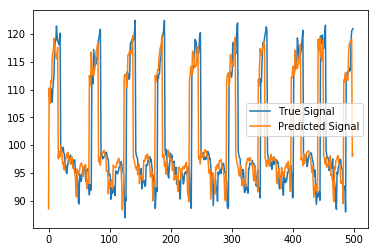

In [35]:
import statsmodels
from statsmodels.tsa.arima_model import AR

df2 = pd.read_csv('./datasets/BATADAL_dataset04.csv')
df2.columns = df2.columns.str.replace(' ', '')

signal = "F_PU1"

# define and fit the AR model
p = 5
model = AR(df[signal])
model_fit = model.fit(p)

# function for predicting next value in serie
def predict(coefficent, history):
    res = coefficent[0]
    for i in range(1, len(coefficent)):
        res += coefficent[i] * history[-i]
    return res

# define the test signal
test = df2[signal]
# obtain AR coefficients
ar_coef = model_fit.params
# keep the first p test signal values  
history = [df2[signal].iloc[x] for x in range(0,p)]

# start predicting!
predictions = list()
for t in range(p,len(test)):
    # next value prediction
    yhat = predict(ar_coef, history)

    # book-keeping
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

# plot first 500 values so that visualization of prediction is better visible
plt.plot(df2[signal][:500].iloc[p:])
plt.plot(predictions[:500])
plt.savefig('ar5plot')
plt.legend(['True Signal','Predicted Signal'])
plt.show()